# Code providing the HVTINY-CNN model

Coyright notice: Code is support for paper R. Dogaru, I. Dogaru, R.C. Tecaru, "A Comparison of Several MCU-Oriented TinyML Models for Skin Lesions Classification", accepted to EHB2025 conference, Iasi - Romania, Nov. 2025 https://www.ehbconference.ro/
Copyright Radu and Ioana DOGARU; Contact radu.dogaru@upb.ro

**Updated - Nov 16, 2025**
The model includes options for nl (in the paper nl=(2,0) ), adding some hidden dense layer (in paper hid=False) and automatically adjust c from the number of elements in profile list.

# Choice of backend:
- JAX usually provides faster training and TPU support but MACs cannot be evaluated.
- Tensorflow allows computation of MAC (computational complexity of the model)
Implicit (not running the cell) Tensorflow  

In [ ]:
import os
os.environ["KERAS_BACKEND"] = 'jax' # tensorflow or jax or torch

# 0. Initialization

In [ ]:
import keras

import numpy as np
print('Backend: ',keras.config.backend())
print('Keras version: ',keras.__version__)


def truncate_float(float_number, decimal_places):
    multiplier = 10 ** decimal_places
    return int(float_number * multiplier) / multiplier

if keras.config.backend()=='tensorflow':
  print('Tensorflow version: ',tf.__version__)
  import tensorflow as tf
  from tensorflow.python.profiler.model_analyzer import profile
  from tensorflow.python.profiler.option_builder import ProfileOptionBuilder
  import tensorflow as tf
  def get_flops(model):
    forward_pass = tf.function(model.call, input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])
    graph_info = profile(forward_pass.get_concrete_function().graph, options=ProfileOptionBuilder.float_operation())
    flops = graph_info.total_float_ops
    return flops

Backend:  jax
Keras version:  3.8.0


# 1.1 - Dataset selection (here from Keras )

In [ ]:
from keras.datasets import mnist, cifar10, cifar100, fashion_mnist

dataset='cifar10' # mnist or f-mnist or cifar10
batch_size=100


datagen=False
out_coding='cat' #
in_coding='clast'  #
test_exists=False

if dataset=='mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
elif  dataset=='cifar10':
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
elif  dataset=='cifar100':
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()

# test/train labels will be used for INT 8 tflite quantization in the representative dataset
test_labels=y_test[:,0]; train_labels=y_train[:,0]
#--- scaling
if (np.ndim(x_train)==3):   # for the mono-chrome sets
        x_train=np.reshape(x_train, [np.shape(x_train)[0],np.shape(x_train)[1],np.shape(x_train)[2], 1])
        x_test=np.reshape(x_test, [np.shape(x_test)[0],np.shape(x_test)[1],np.shape(x_test)[2], 1] )
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /=255

num_classes=int(np.max(y_train)+1)
num_inputs = np.shape(x_test)[1]
input_shape=np.shape(x_train)[1:4]
imsize=input_shape[0]

# categorical style
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
Ntr=np.shape(x_train)[0]; Nva=np.shape(x_test)[0];  # util sa avem numar train / ts
print('Training samples: ',Ntr); print('Validation samples: ',Nva);
print('Classes:   ',num_classes)
print('Input shape : ',input_shape)
print('Batch_size: ',batch_size)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
Training samples:  50000
Validation samples:  10000
Classes:    10
Input shape :  (32, 32, 3)
Batch_size:  100


# 2.0. HVTINY Model - definition
Copyright Radu & Ioana Dogaru radu.dogaru@upb.ro


In [ ]:
# HVTiny CNN
# Low complexity yet accurate model - well suited for MCU-oriented TinyML apps.
# Copyright Radu DOGARU  radu_d@ieee.org , august-october 2025

# Last updated Nov. 16, 2025
#----------------------------------------------------------------------

def hvtiny(input_shape, num_classes, profil=[1, 3, 2], k=60, nl=(1,1), hid=True, flat=0, scale=True, drop=0.3, lr=0.001) :
        kernel_size = (3,3)
        pool_size = (4,4)
        pool_strides = (2,2)
        c=len(profil)-1
        # updated nov. 16 - including nl (original model used nl=2)
        # and automatically adjusted c from the size of profil[]
        print('Profil: ',str(profil))
        drop1=drop
        pad='same'

        if scale:
            inputs = keras.Input(shape=input_shape) / 255 #
        else:
            inputs = keras.Input(shape=input_shape)
        n = int(k)

        # convolutional macro-block 0
        x = keras.layers.Conv2D(n, kernel_size, padding=pad)(inputs)  # Separable
        for i in range(1, nl[0]+1) :
          print('adding')
          x = keras.layers.ReLU()(x)
          x = keras.layers.DepthwiseConv2D(kernel_size, padding=pad)(x)

        #x=keras.layers.BatchNormalization()(x)                        # May help in some cases
        x=keras.layers.MaxPooling2D(pool_size=pool_size,strides=pool_strides,padding=pad)(x)
        if drop1>0:
            x=keras.layers.Dropout(drop1)(x)
        number_of_cells_limited = False

        #adding c macro-blocks 1,2 ... c
        for i in range(1, c + 1) :
            if x.shape[1] <= 1 or x.shape[2] <= 1 :
                number_of_cells_limited = True
                break;

            n=int(k*profil[i])
            x = keras.layers.SeparableConv2D(n, kernel_size, padding=pad)(x)
            if i==1:
              for j in range(1, nl[1]+1) :
                x = keras.layers.ReLU()(x)
                x = keras.layers.DepthwiseConv2D(kernel_size, padding=pad)(x)
            x=keras.layers.MaxPooling2D(pool_size=pool_size,strides=pool_strides,padding=pad)(x)
            if drop1>0:
                x=keras.layers.Dropout(drop1)(x)

        # Output classifier
        if flat==0:
            x = keras.layers.GlobalAveragePooling2D()(x)
        else:
            x= keras.layers.Flatten()(x)
        if hid:   # original model in the paper has hid=False
          x = keras.layers.Dense(n, activation='relu')(x)  # may increase accuracy + extra resources
        x = keras.layers.BatchNormalization()(x)
        x=  keras.layers.Dropout(rate=0.4)(x)
        x = keras.layers.Dense(num_classes)(x)
        outputs = keras.layers.Softmax()(x)
        model = keras.Model(inputs=inputs, outputs=outputs)

        # scheduled rate
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            lr,
            decay_steps=50,
            decay_rate=0.9,
            staircase=False)

        opt = keras.optimizers.Adam(learning_rate=lr) # or lr_schedule

        model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
        return model

# Celula 2.1: A specific model instance  

In [ ]:
version='HVTINY' # HVTINY model defined above
#
myflat=0; my_profil=(1, 4, 3, 2); myk=55; mynl=(1,1); mydrp=0.35; myhid=True
lrate=0.001
myact='relu'  # or 'hard_silu' (may increase accuracy but adds extra resources)
myscale=False  #  false if already scaled ; True elsewhere
model=hvtiny(input_shape=input_shape, num_classes=num_classes, flat=myflat, hid=myhid, profil=my_profil, k=myk, nl=mynl, scale=myscale, drop=mydrp, lr=lrate)
if myscale==False:
    mys='N'
elif myscale==True:
    mys='S'
model_name=version+'_'+mys+'_'+str(myflat)+'_d:'+str(mydrp)+'_'+str(my_profil)+'_k:'+str(myk)+'_nl'+str(mynl)+'_hid:'+str(myhid)
print(model_name)
model.summary()

Profil:  (1, 4, 3, 2)
adding
HVTINY_N_0_d:0.35_(1, 4, 3, 2)_k:55_nl(1, 1)_hid:True


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 55)     │         1,540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 55)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 32, 32, 55)     │           550 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 55)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 55)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 16, 16, 220)    │        12,815 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 16, 16, 220)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_3              │ (None, 16, 16, 220)    │         2,200 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 220)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 220)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 8, 8, 165)      │        38,445 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 165)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 4, 165)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 4, 4, 110)      │        19,745 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 110)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2, 2, 110)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 110)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 110)            │        12,210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 110)            │           440 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 110)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 89,055 (347.87 KB)

 Trainable params: 88,835 (347.01 KB)

 Non-trainable params: 220 (880.00 B)

# MAC complexity

In [ ]:
if keras.config.backend()=='tensorflow':
  flops = get_flops(model)
  macs = flops / 2
  print('Model size: ',model.count_params()//1000,'k ', 'MACs:', macs//1000, 'k')
else:
  print('Actual backend=',keras.config.backend(),' has no support for MACs computing you may switch to tensorflow')
  macs = 0

Actual backend= jax  has no support for MACs computing you may switch to tensorflow


# 3.1 checkpoint

In [ ]:
print('Model size: ',model.count_params()//1000,'k ', 'MACs:', macs//1000, 'k')

from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import time as ti
checkpoint = ModelCheckpoint('best_model.keras', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose=1)

Model size:  89 k  MACs: 0 k


# Celula 3.2. Training process

In [ ]:
epoci= 400  # epochs
import time as ti
t1=ti.time()

if datagen:
  history = model.fit(train_generator, epochs=epoci, validation_data=validation_generator, verbose=1,
                    callbacks = checkpoint)
else:
  history = model.fit(x_train, y_train, epochs=epoci, validation_data=(x_test, y_test), batch_size=batch_size, verbose=1,
                    callbacks = checkpoint)

t2=ti.time()
print('======================Training report  ==============================')
print('Training   ',epoci,' epochs, lasted  ',int(t2-t1)/60,' minutes')
my_eptr=truncate_float((t2-t1)/epoci,1)
model=load_model('best_model.keras')
best_val=truncate_float(100*np.max(history.history['val_accuracy']),2) # valid acc
best_tr=truncate_float(100*np.max(history.history['accuracy']),2)   # train acc
t1=ti.time()
if datagen:
    if test_exists:
      score = model.evaluate(test_generator, verbose=0)  # numai daca exista
      best_ts=truncate_float(100*score[1],2)
    else:
      score = model.evaluate(validation_generator, verbose=0)
      best_ts=truncate_float(100*score[1],2)
else:
    score = model.evaluate(x_test, y_test, verbose=0)
    best_ts=truncate_float(100*score[1],2)
t2=ti.time()

print('--------------------------------------')
kpars=truncate_float(model.count_params()/1000,2)
print ('Model size (k-pars): ',kpars)
print(' Best validation accuracy :', best_val,'%')
print('Dataset: ',dataset)
print('Model: ',model_name)
dsz=input_shape[1]
print('Img size: ',dsz)
print('Batch size: ', batch_size)


Epoch 1/400
385/500 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1657 - loss: 2.1676
Epoch 1: val_accuracy improved from -inf to 0.39260, saving model to best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.1934 - loss: 2.1057 - val_accuracy: 0.3926 - val_loss: 1.7020
Epoch 2/400
450/500 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4800 - loss: 1.4145
Epoch 2: val_accuracy improved from 0.39260 to 0.58220, saving model to best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4830 - loss: 1.4079 - val_accuracy: 0.5822 - val_loss: 1.1517
Epoch 3/400
420/500 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5752 - loss: 1.1890
Epoch 3: val_accuracy improved from 0.58220 to 0.62050, saving model to best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5775 - loss: 1.1838 - val_accuracy: 0.6205 - val_loss: 1.1129
Epoch 4/400
431/500 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6260 - loss: 1.0569
Epoch 4: val_accuracy improved 

KeyboardInterrupt: 

381/500 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8099 - loss: 0.5505

# 3.3:  Confusion matrix  

In [ ]:
model = load_model('best_model.keras')
from sklearn.metrics import classification_report, confusion_matrix

if datagen:
    t1=ti.time()
    if test_exists:
        accuracy = model.evaluate(test_generator)[1]
    else:
        accuracy = model.evaluate(validation_generator)[1]
    t2=ti.time()
    print(f"Acuratete set test = {accuracy*100} %")
    print ('Dimensiune model (parametri): ',model.count_params())
    print('Latenta per intreg set test: ', 1000*(t2-t1), 'mili seconds')
    if test_exists:
        mygen=test_generator
        my_latency=truncate_float(1000*(t2-t1)/N_test,2)
        print ('Timp predictie per esantion in setul de test: ',my_latency, 'ms' )
    else:
        mygen=validation_generator
        my_latency=truncate_float(1000*(t2-t1)/sbatch_size,2)
        print ('Timp predictie per esantion in setul de validare: ',my_latency, 'ms' )
    for i,j in mygen:
        print(i.shape, j.shape)
        p = model.predict(i)
        pq= p.argmax(-1)
        labels=(np.dot(j,np.array(range(num_classes)).T)).astype('int16')
        break;
    print(classification_report(labels,pq))
    print(confusion_matrix(labels,pq))
else:

   # Confusion matrix and more specific performance indicators
#----------------------------------------------------------------

    labels=(np.dot(y_test,np.array(range(num_classes)).T)).astype('int16')
    t1=ti.time()
    pred= model.predict(x_test)
    t2=ti.time()
    my_latency=truncate_float(1000*(t2-t1)/(x_test.shape[0]),2)
    print ('Latency: ',my_latency, 'ms' )

    predicted_class_indices=np.argmax(pred,axis=1)
    C=confusion_matrix(predicted_class_indices,labels)
    print (C)
    print('Classification Report')
    print(classification_report(labels,predicted_class_indices ))

if test_exists:
    tsts='|TestData|Ts_acc: '+str(best_ts)
else:
    tsts='ValData|Val_acc:'+str(best_ts)

my_MAC=truncate_float(macs//1000,2)
rep='_'+model_name+'_'+dataset+' Sz|'+str(dsz)+' Bt|'+str(batch_size)+' Lrate: '+str(lrate)+' Ep|'+str(epoci)
rep=rep+' Tep|'+str(my_eptr)+' Kpar|'+str(kpars)+'kMAC'+str(my_MAC)+' Vacc|'+str(best_val)+' TrAcc|'+str(best_tr)
rep=rep+tsts+' Lat|'+str(my_latency)
print('Repname: '+rep)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Latency:  0.38 ms
[[893  10  32  15   6   8   3   7  46  19]
 [  9 931   1   4   1   2   1   1  12  46]
 [ 16   3 810  42  29  25  15  11   5   3]
 [  6   0  15 656  11  67  10  16   3   3]
 [ 12   1  42  58 901  36  14  43   0   0]
 [  1   2  31 128  13 819   9  28   2   3]
 [  9   1  50  66  21  24 943   6   6   3]
 [ 10   1  13  22  15  19   2 886   4   3]
 [ 29  10   5   3   3   0   1   0 911  11]
 [ 15  41   1   6   0   0   2   2  11 909]]
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1000
           1       0.92      0.93      0.93      1000
           2       0.84      0.81      0.83      1000
           3       0.83      0.66      0.73      1000
           4       0.81      0.90      0.86      1000
           5       0.79      0.82      0.80      1000
           6       0.84      0.94      0.89      1000
           7       0.91      0.89      0.90      1000
 

# Training progress


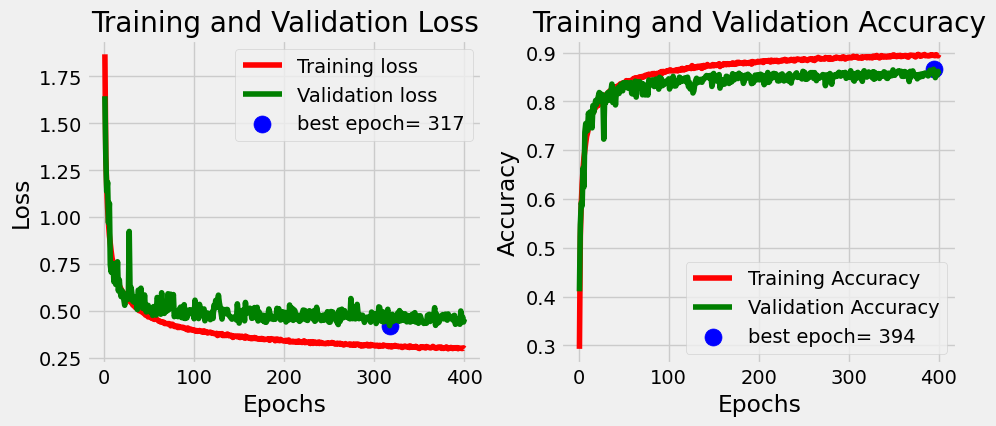

In [ ]:

# adapted from  https://www.kaggle.com/code/youssefabdelghfar/brain-tumor-using-efficientnetb3
#print(rep)

from matplotlib import pyplot as plt
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (10, 4))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
model.save(rep+'.keras')